In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision.utils import make_grid

### Doing some transformation to the dataset like normalization, resizing, grayscaling

In [ ]:
# transformation to the image dataseet:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           # Convert images to PyTorch tensors and scale to [0, 1]
])


### Specifying the path to the dataset.
### Below is the path of the kaggle dataset hosted on kaggle (please, use it if you run the notebook on kaggle notebook).
#### If you run the notebook on other platforms, you need to modify the path.

In [ ]:
train_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/"
test_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/"

#### Applying the already definded transformation to the dataset

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)


####  Loading the training dataset in a way that optimizes the training process

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


#### Get one batch of images and Visualizae sample images

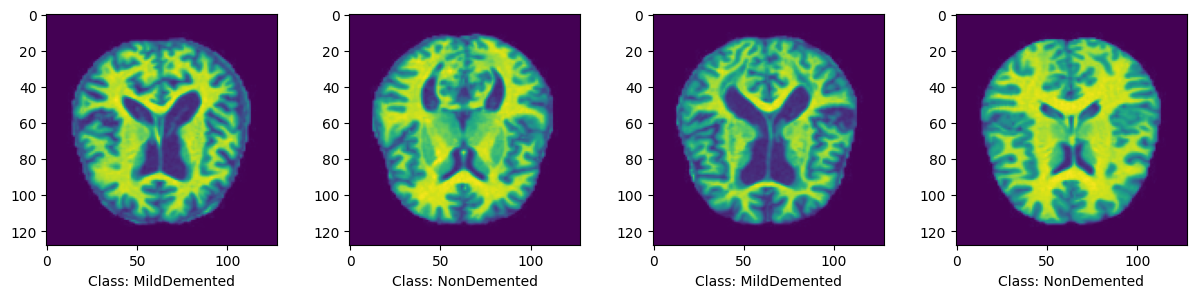

In [ ]:
# Get one batch of images
images, labels = next(iter(train_loader))

# Number of images you want to display
num_images = 4

# Create a grid for the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

class_names = train_dataset.classes

for i in range(num_images):
    # Convert image tensor to numpy array and transpose the axes
    # PyTorch tensors are in (C, H, W) format, and Matplotlib expects (H, W, C)
    img = images[i].numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('on')  # Turn off axis
    axes[i].set_xlabel(f'Class: {class_names[labels[i].item()]}') # Set the label as x-axis label

plt.show()

## Number of images in each class (Histogram).

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


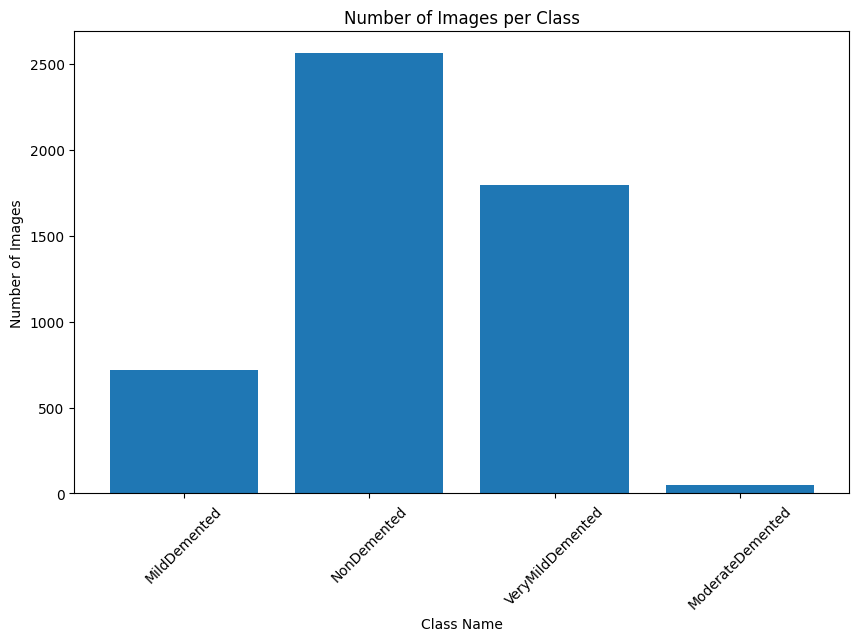

In [ ]:
class_names = train_dataset.classes
print(class_names)

# Initialize a Counter to hold the count of each class
class_counts = Counter()
# Iterate over the DataLoader to count labels
for _, labels in train_loader:
    class_counts.update(labels.tolist())

# Convert the counts to lists for plotting
class_indices, counts = zip(*class_counts.items())
class_labels = [class_names[i] for i in class_indices]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_labels, counts, align='center')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate class names for better readability
plt.title('Number of Images per Class')
plt.show()

### The number of images in each class

In [ ]:
class_counts = Counter([label for _, label in train_dataset])

# Print the class name and the number of images in each class
for class_index, count in class_counts.items():
    print(f"{train_dataset.classes[class_index]}: {count}")

MildDemented: 717
ModerateDemented: 52
NonDemented: 2560
VeryMildDemented: 1792


### Utility function (helper) to get the size of the flattened output to prepare it to the dense layer.
#### This function assumes you have two convolutional layers and max pooling(downsampling) after each convolutioonal layer.
#### In case you want to add more conv layers, you need to modify this function before.
    



In [ ]:
def calculate_flattened_output(input_size, input_channels,
                               conv1_filter_size, conv1_filters, conv1_stride,
                               conv2_filter_size, conv2_filters, conv2_stride,
                               pool_size, pool_stride):
    # Function to calculate output size of conv layer
    def conv_output_size(size, filter_size, stride):
        return (size - filter_size) // stride + 1

    # Function to calculate output size of pool layer
    def pool_output_size(size, pool_size, pool_stride):
        return (size - pool_size) // pool_stride + 1

    # Calculate output size after each layer
    conv1_output = conv_output_size(input_size, conv1_filter_size, conv1_stride)
    pool1_output = pool_output_size(conv1_output, pool_size, pool_stride)

    conv2_output = conv_output_size(pool1_output, conv2_filter_size, conv2_stride)
    pool2_output = pool_output_size(conv2_output, pool_size, pool_stride)

    # Calculate flattened output size
    flattened_output = pool2_output * pool2_output * conv2_filters
    return flattened_output

# Example call
output_size = calculate_flattened_output(128, 1, 3, 16, 1, 3, 32, 1, 2, 2)
print(output_size)


28800


## Building the CNN architecture:
### - Convolutional layer:
####  serves the purpose of extracting features from input images. It applies filters (also known as kernels) to the input image to create feature maps
### - Pooling:
####  reduces the spatial size of feature maps. It helps in making the detection of features             invariant to scale and orientation changes.
### - Activation Function:
####   It introduces non-linearity to the model, which is essential for learning complex patterns          in data.
### - Flattening:
####  is used to convert the multi-dimensional output of the preceding layers (like convolutional         and pooling layers) into a one-dimensional array
### - Dense Layers (Fully Connected FC):
####  The purpose of these layers is to perform high-level reasoning from the features extracted by        previous layers. Dense layers are where the network combines these features to make final          predictions or decisions, such as classifying an image.

![1-4.png](attachment:4f0b8934-2159-4f4b-a76a-ddc84da15e24.png)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU() # activation function x:+{x}, - {0}
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(output_size, 64) #flattening
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 4)  # 2 output classes: 4
        ## activation function: softmax

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 30 * 30)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

### Spliting the dataset (train folder) into training and validating data.
#### This technique is called *Cross Validation* CV and commonly used as it helps to address the issue of overfitting.
#### *Overfitting* is a problem when the model performs well on the training data but very baddly on unforseen data.

In [ ]:
# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
# Create data loaders
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
# Initialize the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28800, out_features=64, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")

Epoch 1/10, Train Loss: 0.9986, Val Loss: 1.0645, Val Accuracy: 0.5190243902439025
Epoch 2/10, Train Loss: 0.8662, Val Loss: 0.7920, Val Accuracy: 0.6185365853658537
Epoch 3/10, Train Loss: 0.7075, Val Loss: 0.6023, Val Accuracy: 0.735609756097561
Epoch 4/10, Train Loss: 0.5276, Val Loss: 0.5216, Val Accuracy: 0.7736585365853659
Epoch 5/10, Train Loss: 0.3614, Val Loss: 0.3550, Val Accuracy: 0.8595121951219512
Epoch 6/10, Train Loss: 0.2288, Val Loss: 0.2357, Val Accuracy: 0.911219512195122
Epoch 7/10, Train Loss: 0.1524, Val Loss: 0.2096, Val Accuracy: 0.9190243902439025
Epoch 8/10, Train Loss: 0.1048, Val Loss: 0.2243, Val Accuracy: 0.9248780487804878
Epoch 9/10, Train Loss: 0.0720, Val Loss: 0.1202, Val Accuracy: 0.9482926829268292
Epoch 10/10, Train Loss: 0.0711, Val Loss: 0.3081, Val Accuracy: 0.8936585365853659


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'AD_cnn_model.pth')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Storage for predictions and actual labels
all_preds = []
all_labels = []

# Evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics for each class
for class_index in range(4):  # Replace num_classes with the actual number of classes
    class_preds = (all_preds == class_index)
    class_labels = (all_labels == class_index)
    accuracy = accuracy_score(class_labels, class_preds)
    precision = precision_score(class_labels, class_preds, zero_division=0)
    recall = recall_score(class_labels, class_preds, zero_division=0)

    class_name = class_names[class_index]

    print(f"Class name {class_name}({class_index}) - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


Class name MildDemented(0) - Accuracy: 0.8655199374511336, Precision: 0.5402298850574713, Recall: 0.26256983240223464
Class name ModerateDemented(1) - Accuracy: 0.9913995308835027, Precision: 0.6666666666666666, Recall: 0.16666666666666666
Class name NonDemented(2) - Accuracy: 0.6497263487099296, Precision: 0.6059602649006622, Recall: 0.8578125
Class name VeryMildDemented(3) - Accuracy: 0.6927286942924159, Precision: 0.5971731448763251, Recall: 0.37723214285714285


### And finally how to test on unforseen image:

In [ ]:
### Confusion Matrix

In [ ]:
# Load the image and preprocess it
from PIL import Image

#image = Image.open(r"imagefile.jpg")
#image_tensor = transform(image).unsqueeze(0).to(device)

## Whaat else we can do to improve the performance?
### - Increase number of conv layers.
### - Add extra dense layer.
### - Introducing dropout parameter
### - Augment the dataset.